In [ ]:
import matplotlib.pyplot as plt

from scripts.viz_utils import *
from scipy import stats

data = pd.read_csv('../data/data_scales.csv', index_col='ResponseId')
plots_path = '../plots/main_effect'

tia_scales = ['tia_f', 'tia_pro', 'tia_rc', 'tia_t', 'tia_up']
scale_titles = {
    'ati': 'Affinity for Technology Interaction',
    'hcsds_c': 'Healthcare Trust - Competence',
    'hcsds_v': 'Healthcare Trust - Values',
    'tia_rc': 'TiA - Reliability/Confidence',
    'tia_up': 'TiA - Understanding/Predictability',
    'tia_f': 'TiA - Familiarity',
    'tia_pro': 'TiA - Propensity to Trust',
    'tia_t': 'TiA - Trust in Automation'
}

def format_dict(dict):
    string = ''
    for key, value in dict.items():
        if hasattr(value, '__iter__'):
            string += f'{key}: '
            for item in value:
                string += f'{item:.2f}, '
            string = string[:-2] # remove last comma
            string += '\n'
        else:
            string += f'{key}: {value:.2f}\n'
    return string

### Overview

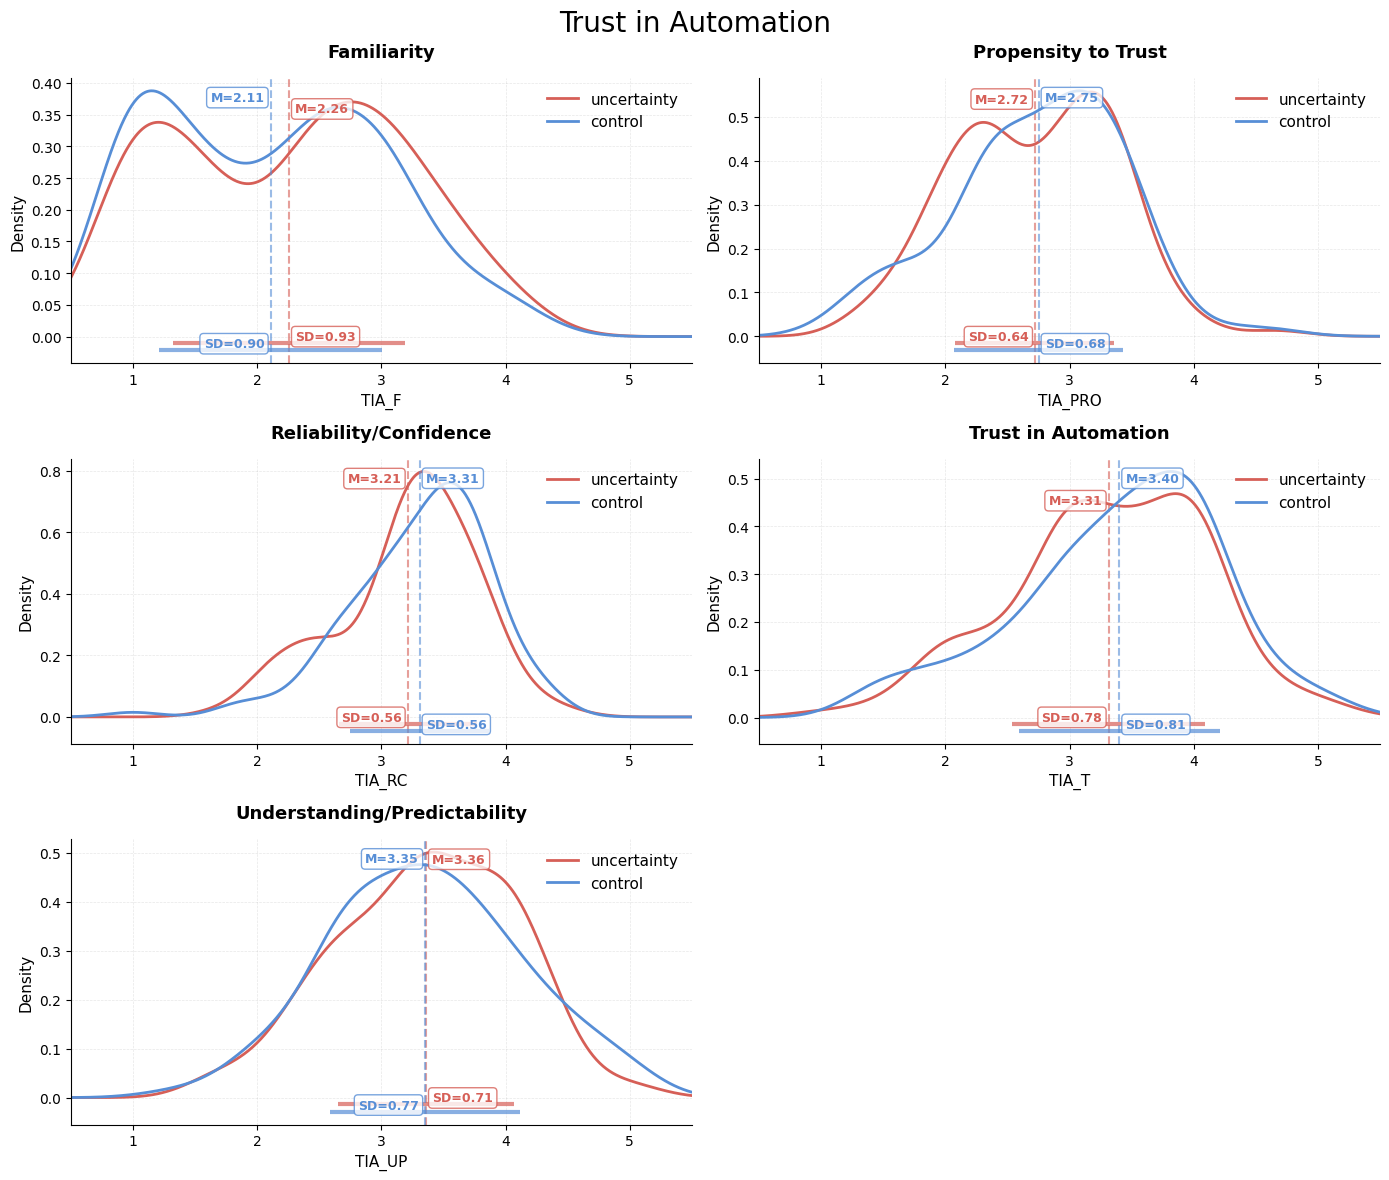

In [3]:
fig, axes = create_figure_grid(len(tia_scales), ncols=2, figsize=(14, 12))

for idx, scale in enumerate(tia_scales):
    plot_likert_distribution(data, scale, title=scale_titles.get(scale)[6:],
                             group_by='stimulus_group', ax=axes[idx],
                             show_stats=True,
                             show_correlation=False,
                             show_bars=False, show_kde=True)

fig.suptitle("Trust in Automation", fontsize=20)

plt.tight_layout()
plt.savefig(f'{plots_path}/main_effect_overview.png', transparent=True)
plt.show()

### Power Analysis
Compute smallest effect size that *can* be measured with acquired sample (see Lakens, 2017).

In [4]:
# sample size
N = [0, 0]
N[0] = len(data[data['stimulus_group'] == 0])
N[1] = len(data[data['stimulus_group'] == 1])

print(f'total participants:\tN = {len(data)}\n'
      f'\tuncertainty:\tN = {N[0]}\n'
      f'\tcontrol:\t\tN = {N[1]}\n')

total participants:	N = 255
	uncertainty:	N = 126
	control:		N = 129



In [5]:
# mean and standard deviation per scale
means = {}
stds = {}

for scale in tia_scales:
    means[scale] = [0, 0]
    means[scale][0] = np.mean(data[scale][data['stimulus_group'] == 0])
    means[scale][1] = np.mean(data[scale][data['stimulus_group'] == 1])

    stds[scale] = [0, 0]
    stds[scale][0] = np.std(data[scale][data['stimulus_group'] == 0])
    stds[scale][1] = np.std(data[scale][data['stimulus_group'] == 1])

print(f'means:\n{format_dict(means)}')
print(f'standard deviations:\n{format_dict(stds)}')

means:
tia_f: 2.11, 2.26
tia_pro: 2.75, 2.72
tia_rc: 3.31, 3.21
tia_t: 3.40, 3.31
tia_up: 3.35, 3.36

standard deviations:
tia_f: 0.90, 0.93
tia_pro: 0.68, 0.64
tia_rc: 0.56, 0.55
tia_t: 0.80, 0.78
tia_up: 0.76, 0.70



In [6]:
# minimally detectable effect size (power analysis)
from scipy import stats

alpha = 0.05

M_crits = {} # minimally detectable effect size
se = {}  # standard error

for scale in tia_scales:
    s1, s2 = stds[scale][0], stds[scale][1]
    n1, n2 = N[0], N[1]

    # standard error
    se[scale] = np.sqrt((s1**2 / n1) + (s2**2 / n2))
    
    # degrees of freedom (using Welch-Satterthwaite approximation for unequal variances)
    numerator = (s1**2/n1 + s2**2/n2)**2
    denominator = (s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1)
    df = numerator / denominator
    
    # Get critical t-value for one-tailed test
    t_crit = stats.t.ppf(1 - alpha, df)
    
    # Calculate critical mean difference
    M_crits[scale] = t_crit * np.sqrt((s1**2 / n1) + (s2**2 / n2))

print(f'standard errors:\n{format_dict(se)}')
print(f'M_crit:\n{format_dict(M_crits)}')

standard errors:
tia_f: 0.11
tia_pro: 0.08
tia_rc: 0.07
tia_t: 0.10
tia_up: 0.09

M_crit:
tia_f: 0.19
tia_pro: 0.14
tia_rc: 0.11
tia_t: 0.16
tia_up: 0.15



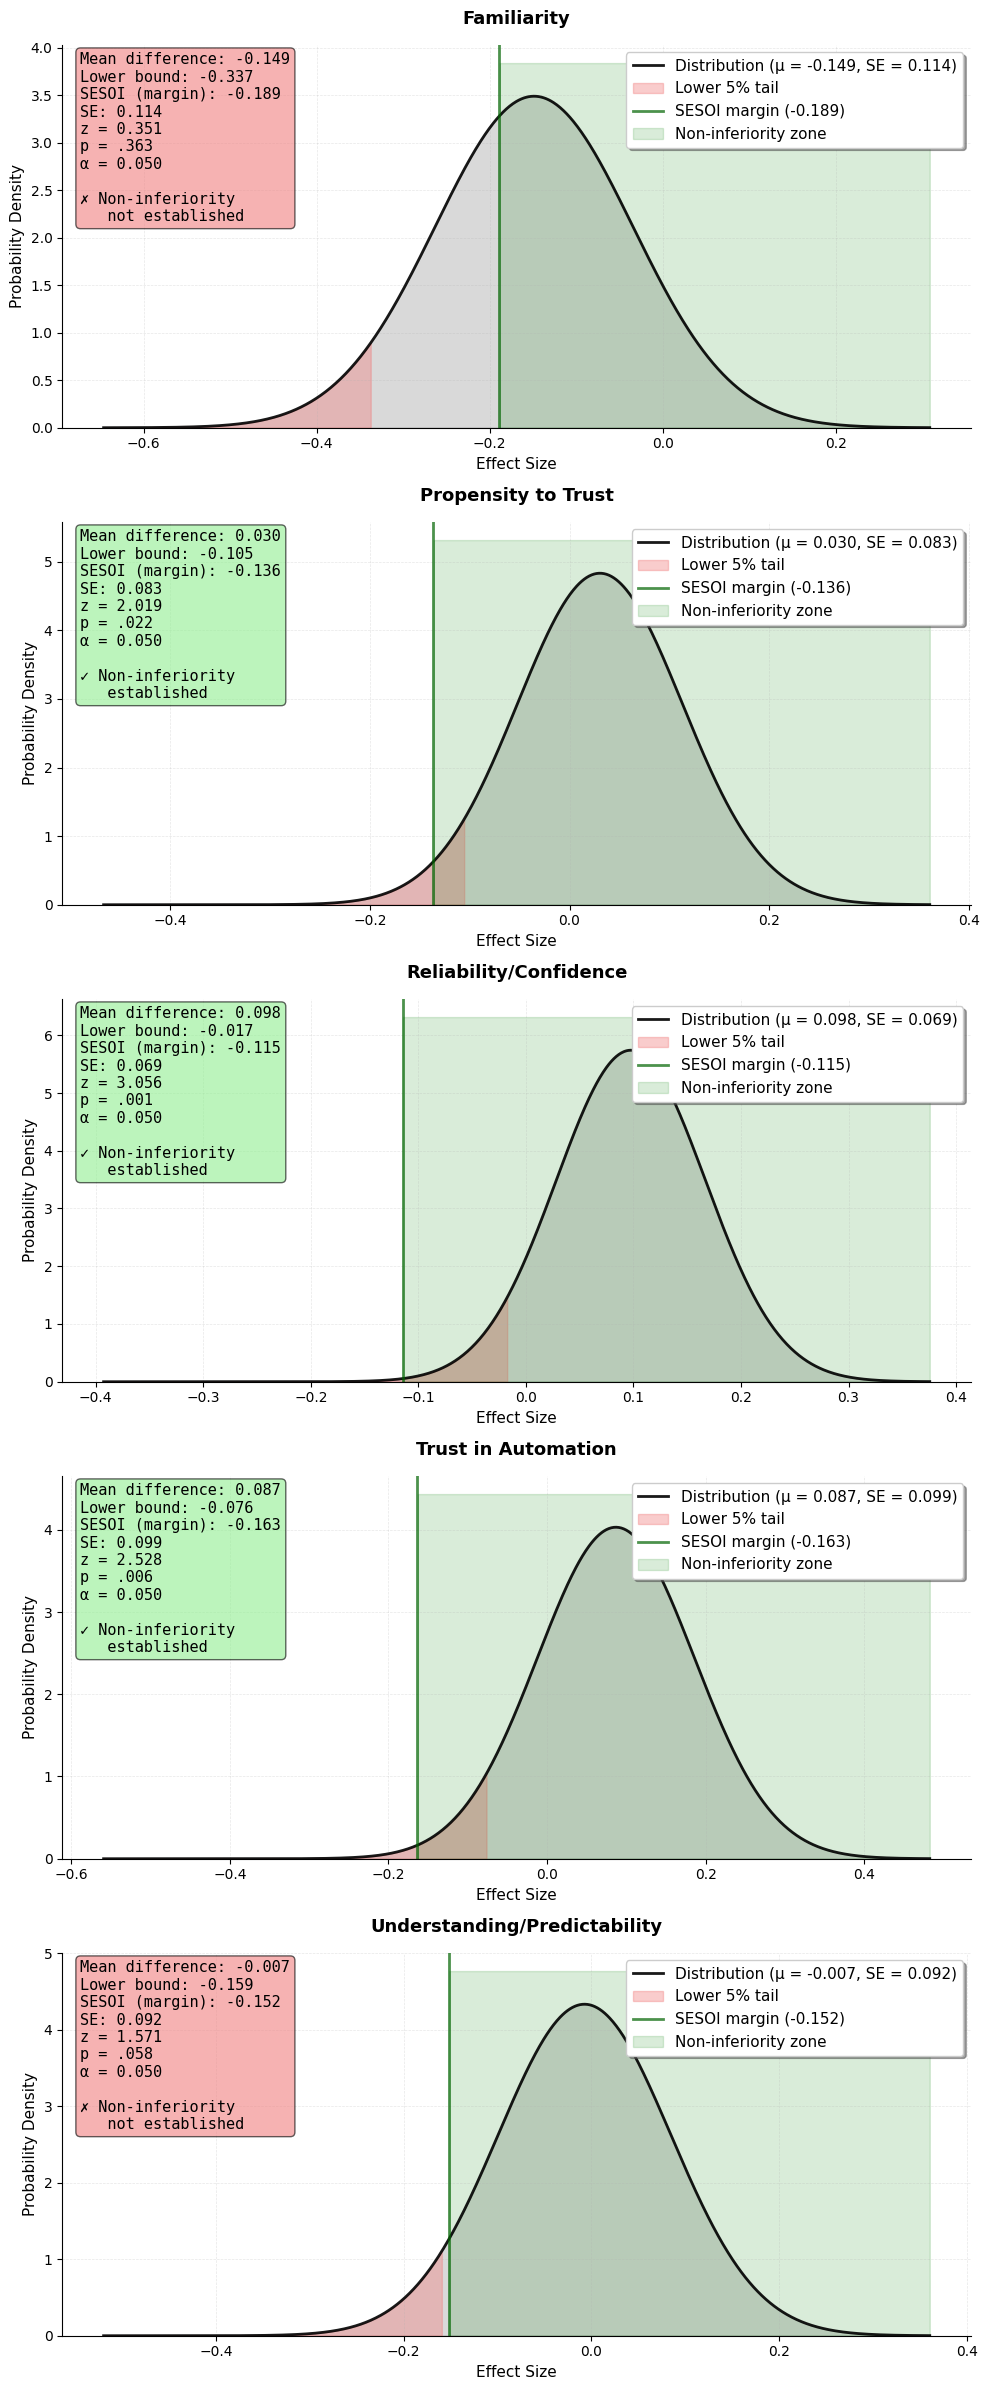

In [7]:
# plot
fig, axs = create_figure_grid(len(tia_scales), ncols=1, figsize=(10,24))

for i, scale in enumerate(tia_scales):
    mean_diff = means[scale][0] - means[scale][1]
    plot_noninferiority_test(mean_diff=mean_diff,
                             sesoi=M_crits[scale],
                             se=se[scale],
                             alpha=0.05,
                             title=f'{scale_titles.get(scale)[6:]}',
                             ax=axs[i])


plt.tight_layout()
plt.show()